<a name='1'></a>
## 1 - Packages

As usual, begin by loading in the packages.

In [2]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow_datasets as tfds
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<a name='1'></a>
## 2 - Dataset

Loading datasets, split tran, validation and test datasets.

In [3]:
data_dir = '../input/chinese-calligraphy-styles-by-calligraphers/data/data'

In [4]:
builder = tfds.ImageFolder(data_dir)
print(builder.info)

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='/root/tensorflow_datasets/image_folder/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=20),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=21007, num_shards=1>,
        'train': <SplitInfo num_examples=84022, num_shards=1>,
    },
    citation="""""",
)


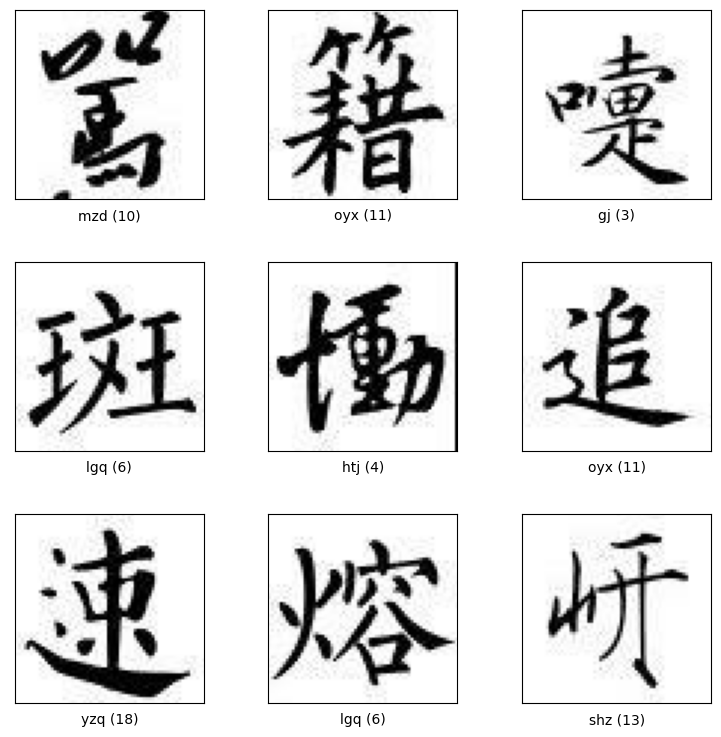

84022


In [5]:
train_ds = builder.as_dataset(split='train', shuffle_files=True, as_supervised=True)
tfds.show_examples(train_ds, builder.info)
num_examples = builder.info.splits['train'].num_examples
print(num_examples)

In [6]:
test_ds = builder.as_dataset(split='test', shuffle_files=True, as_supervised=True)
num_test_examples = builder.info.splits['test'].num_examples
print(num_test_examples)

21007


In [7]:
def preprocess():
    def preprocess_func(img, y):
        img = tf.image.convert_image_dtype(img, dtype=tf.float32)
        return img, y

    return preprocess_func

train_ds = train_ds.map(preprocess(), num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(preprocess(), num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
train_ds, valid_ds = tf.keras.utils.split_dataset(train_ds, left_size=0.9)

print(int(train_ds.cardinality()))
print(int(valid_ds.cardinality()))
print(int(test_ds.cardinality()))

75620
8402
21007


In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch)
  break

(64, 64, 3)
tf.Tensor(17, shape=(), dtype=int64)


In [10]:
for images, labels in valid_ds:
  print(images.shape)
  print(labels.shape)
  break

(64, 64, 3)
()


In [11]:
label_names = builder.info.features['label'].names
print(label_names)

['bdsr', 'csl', 'fwq', 'gj', 'htj', 'hy', 'lgq', 'lqs', 'lx', 'mf', 'mzd', 'oyx', 'sgt', 'shz', 'smh', 'wxz', 'wzm', 'yyr', 'yzq', 'zmf']


In [12]:
import os

for class_ in label_names:
    print("Class "+ class_ + ": " + str(len(os.listdir(data_dir + "/train/" + class_))))

Class bdsr: 1588
Class csl: 860
Class fwq: 5410
Class gj: 5410
Class htj: 5371
Class hy: 2665
Class lgq: 5410
Class lqs: 5406
Class lx: 5410
Class mf: 5410
Class mzd: 5410
Class oyx: 2808
Class sgt: 5001
Class shz: 5410
Class smh: 1014
Class wxz: 5393
Class wzm: 3621
Class yyr: 5410
Class yzq: 5405
Class zmf: 1610


In [13]:
for class_ in label_names:
    print("Class "+ class_ + ": " + str(len(os.listdir(data_dir + "/test/" + class_))))

Class bdsr: 397
Class csl: 215
Class fwq: 1353
Class gj: 1353
Class htj: 1343
Class hy: 666
Class lgq: 1353
Class lqs: 1351
Class lx: 1353
Class mf: 1353
Class mzd: 1353
Class oyx: 702
Class sgt: 1250
Class shz: 1353
Class smh: 253
Class wxz: 1348
Class wzm: 905
Class yyr: 1353
Class yzq: 1351
Class zmf: 402


In [14]:
batch_size = 128
train_ds, valid_ds, test_ds = [ds.batch(batch_size, drop_remainder=False) for ds in [train_ds, valid_ds, test_ds]]

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 64, 64, 3)
(128,)


In [16]:
print(int(train_ds.cardinality()))
print(int(test_ds.cardinality()))

591
165


<a name='1'></a>
## 3 - Models

<a name='1'></a>
### ResNet Fine Tuning

ResNet50 from TensorFlow

In [32]:
from tensorflow.keras.applications import ResNet50

resnet_weights_path = '../input/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [33]:
model1 = tf.keras.Sequential()

base_model = ResNet50(include_top = False, pooling = 'avg', weights = resnet_weights_path)

model1.add(base_model)

model1.add(tf.keras.layers.Dense(20))

base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 150

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

for layer in base_model.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = False

In [34]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_6 (Dense)             (None, 20)                40980     
                                                                 
Total params: 23,628,692
Trainable params: 10,010,644
Non-trainable params: 13,618,048
_________________________________________________________________


In [35]:
model1.compile(
  optimizer = 'adam',
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
  metrics = ['accuracy'])

In [40]:
history = model1.fit(
  train_ds,
  validation_data = valid_ds,
  epochs = 10
)

Epoch 1/6
591/591 [==============================] - 2379s 4s/step - loss: 1.4721 - accuracy: 0.5194 - val_loss: 1.2103 - val_accuracy: 0.6096
Epoch 2/6
591/591 [==============================] - 2246s 4s/step - loss: 1.0584 - accuracy: 0.6491 - val_loss: 1.0076 - val_accuracy: 0.6677
Epoch 3/6
591/591 [==============================] - 2396s 4s/step - loss: 0.9477 - accuracy: 0.6850 - val_loss: 0.9470 - val_accuracy: 0.6881
Epoch 4/6
591/591 [==============================] - 2300s 4s/step - loss: 0.8773 - accuracy: 0.7075 - val_loss: 0.8869 - val_accuracy: 0.7098
Epoch 5/6
591/591 [==============================] - 2355s 4s/step - loss: 0.8200 - accuracy: 0.7253 - val_loss: 0.8550 - val_accuracy: 0.7251
Epoch 6/6
591/591 [==============================] - 2250s 4s/step - loss: 0.7798 - accuracy: 0.7410 - val_loss: 0.8547 - val_accuracy: 0.7265


In [1]:
evaluation1 = model1.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation1.items():
  print(f"{name}: {value:.4f}")

NameError: name 'model' is not defined

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


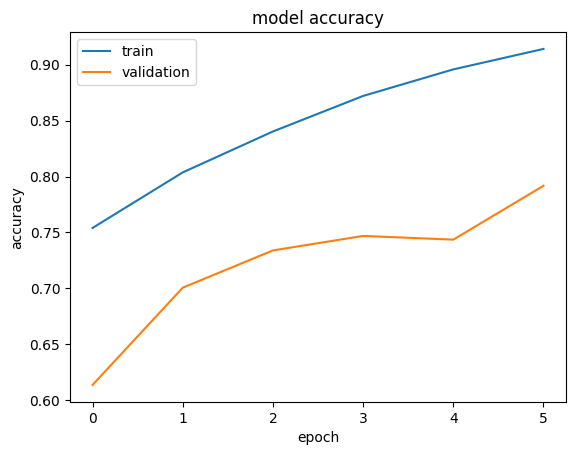

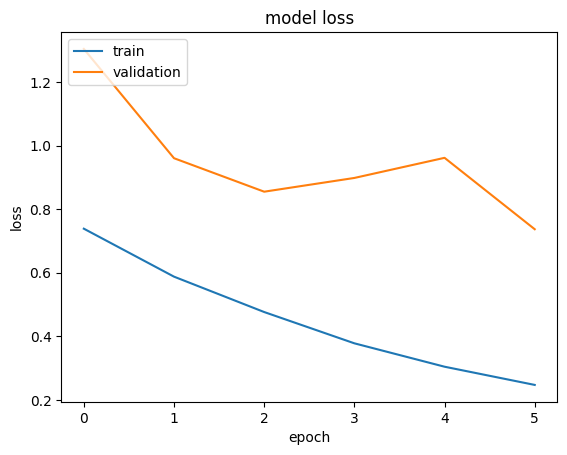

In [32]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [37]:
pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 24.5 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [38]:
import visualkeras
visualkeras.layered_view(model1)

<a name='1'></a>
### Customized CNN


In [27]:
model2 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(64, 64, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(20)
])

In [28]:
model2.compile(
  optimizer = 'adam',
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics = ['accuracy'])

In [29]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 128)      

In [30]:
history = model2.fit(
  train_ds,
  validation_data = valid_ds,
  epochs = 12
)

Epoch 1/12
591/591 [==============================] - 548s 925ms/step - loss: 2.1306 - accuracy: 0.3128 - val_loss: 1.0348 - val_accuracy: 0.6688
Epoch 2/12
591/591 [==============================] - 543s 918ms/step - loss: 0.7708 - accuracy: 0.7500 - val_loss: 0.6424 - val_accuracy: 0.7918
Epoch 3/12
591/591 [==============================] - 538s 911ms/step - loss: 0.5545 - accuracy: 0.8189 - val_loss: 0.5078 - val_accuracy: 0.8372
Epoch 4/12
591/591 [==============================] - 540s 914ms/step - loss: 0.4499 - accuracy: 0.8523 - val_loss: 0.4937 - val_accuracy: 0.8386
Epoch 5/12
591/591 [==============================] - 540s 914ms/step - loss: 0.3783 - accuracy: 0.8754 - val_loss: 0.3972 - val_accuracy: 0.8716
Epoch 6/12
591/591 [==============================] - 540s 914ms/step - loss: 0.3238 - accuracy: 0.8937 - val_loss: 0.3641 - val_accuracy: 0.8809
Epoch 7/12
591/591 [==============================] - 542s 918ms/step - loss: 0.2725 - accuracy: 0.9098 - val_loss: 0.3316 -

In [31]:
history.history

{'loss': [2.1306324005126953,
  0.7708310484886169,
  0.5545027852058411,
  0.44989266991615295,
  0.3782832622528076,
  0.32381653785705566,
  0.2725226879119873,
  0.23189689218997955,
  0.2057596892118454,
  0.17693471908569336,
  0.14643467962741852,
  0.13009749352931976],
 'accuracy': [0.3127743899822235,
  0.7499867677688599,
  0.8188706636428833,
  0.852287769317627,
  0.8753636479377747,
  0.8936656713485718,
  0.9097857475280762,
  0.9235784411430359,
  0.931155800819397,
  0.941483736038208,
  0.9516265392303467,
  0.9556863307952881],
 'val_loss': [1.0348485708236694,
  0.6424071788787842,
  0.5078077912330627,
  0.49365490674972534,
  0.397247314453125,
  0.3641214370727539,
  0.33158889412879944,
  0.3210211396217346,
  0.29810237884521484,
  0.312730997800827,
  0.31568488478660583,
  0.34834879636764526],
 'val_accuracy': [0.668769359588623,
  0.7918352484703064,
  0.8371816277503967,
  0.8386098742485046,
  0.8715782165527344,
  0.8808616995811462,
  0.8933587074279785

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


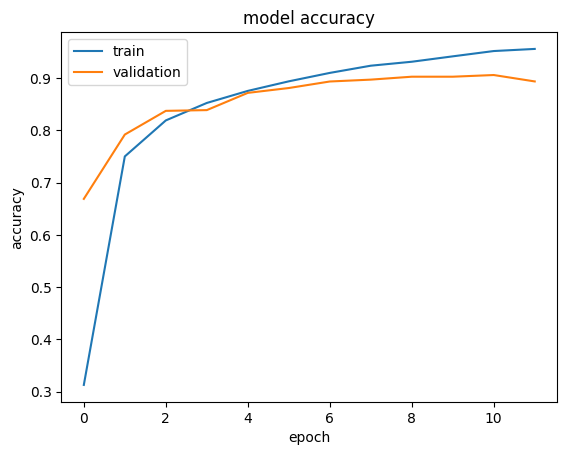

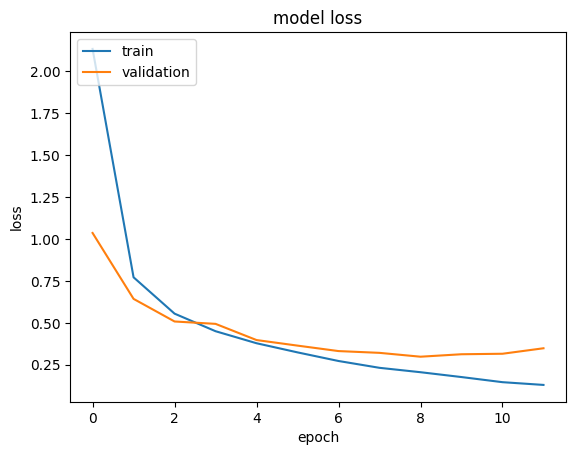

In [32]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [33]:
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)

print(int(test_ds.cardinality()))

165


In [34]:
evaluation2 = model2.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation2.items():
  print(f"{name}: {value:.4f}")

165/165 [==============================] - 41s 242ms/step - loss: 0.3488 - accuracy: 0.8982

loss: 0.3488
accuracy: 0.8982


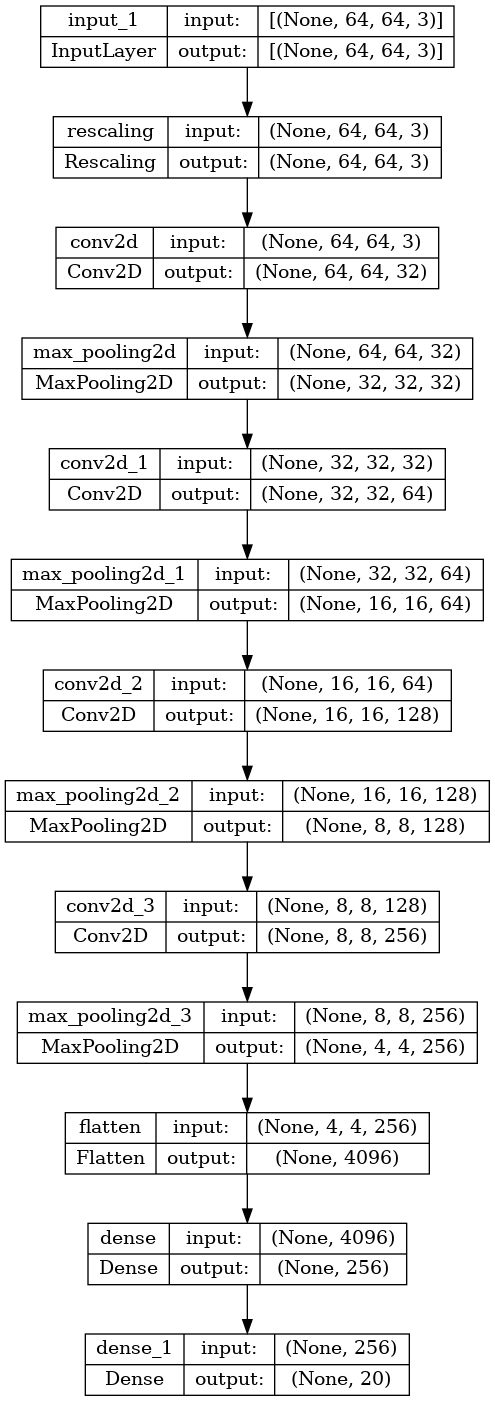

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [26]:
pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 15.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


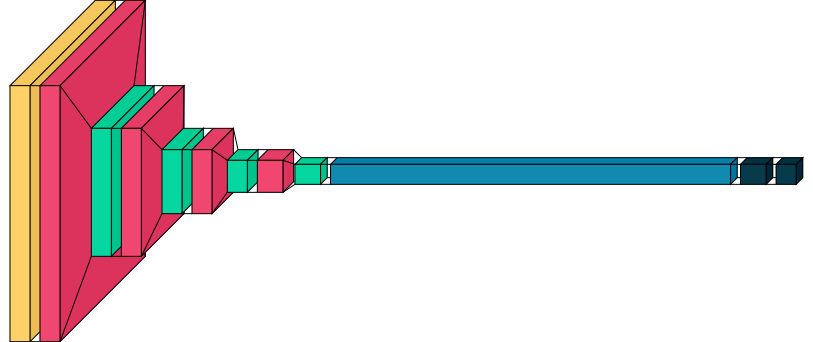

In [27]:
import visualkeras
visualkeras.layered_view(model)

<a name='1'></a>
### Customized Deeper CNN

In [ ]:
model3 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(64, 64, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding = 'same'),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding = 'same'),
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(20)
])

In [ ]:
model3.compile(
  optimizer = 'adam',
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics = ['accuracy'])

model3.summary()

In [26]:
history = model3.fit(
  train_ds,
  validation_data = valid_ds,
  epochs = 10
)

Epoch 1/10
591/591 [==============================] - 573s 966ms/step - loss: 2.9007 - accuracy: 0.0651 - val_loss: 2.8989 - val_accuracy: 0.0674
Epoch 2/10
591/591 [==============================] - 571s 966ms/step - loss: 2.8974 - accuracy: 0.0648 - val_loss: 2.8968 - val_accuracy: 0.0619
Epoch 3/10
591/591 [==============================] - 568s 961ms/step - loss: 2.8970 - accuracy: 0.0654 - val_loss: 2.8968 - val_accuracy: 0.0619
Epoch 4/10
591/591 [==============================] - 565s 956ms/step - loss: 2.8968 - accuracy: 0.0649 - val_loss: 2.8967 - val_accuracy: 0.0619
Epoch 5/10
591/591 [==============================] - 568s 960ms/step - loss: 2.8967 - accuracy: 0.0644 - val_loss: 2.8965 - val_accuracy: 0.0619
Epoch 6/10
591/591 [==============================] - 568s 961ms/step - loss: 2.8966 - accuracy: 0.0643 - val_loss: 2.8964 - val_accuracy: 0.0619
Epoch 7/10
591/591 [==============================] - 565s 955ms/step - loss: 2.8965 - accuracy: 0.0645 - val_loss: 2.8963 -

In [27]:
history.history

{'loss': [2.900728940963745,
  2.897357225418091,
  2.896988868713379,
  2.896840810775757,
  2.8967039585113525,
  2.8965866565704346,
  2.8964924812316895,
  2.896402359008789,
  2.8963634967803955,
  2.896310806274414],
 'accuracy': [0.06512827426195145,
  0.0647844448685646,
  0.06537953019142151,
  0.06494313478469849,
  0.06436128169298172,
  0.06430838257074356,
  0.06450674682855606,
  0.06481089442968369,
  0.06455963850021362,
  0.06440094858407974],
 'val_loss': [2.8988561630249023,
  2.8968443870544434,
  2.896810531616211,
  2.8966987133026123,
  2.896507740020752,
  2.8963866233825684,
  2.8962860107421875,
  2.8962247371673584,
  2.896129608154297,
  2.896069049835205],
 'val_accuracy': [0.06736491620540619,
  0.061890024691820145,
  0.061890024691820145,
  0.061890024691820145,
  0.061890024691820145,
  0.061890024691820145,
  0.061890024691820145,
  0.061890024691820145,
  0.061890024691820145,
  0.061890024691820145]}

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


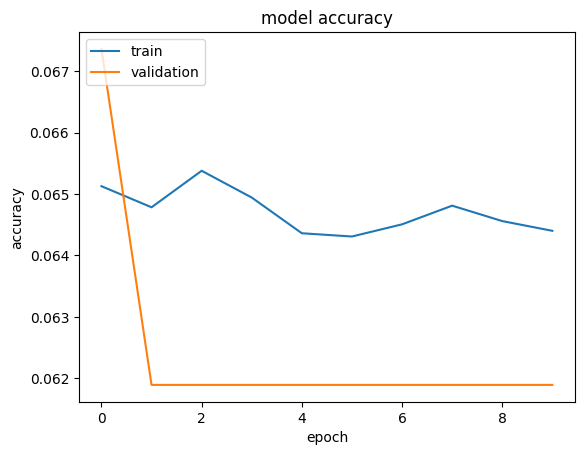

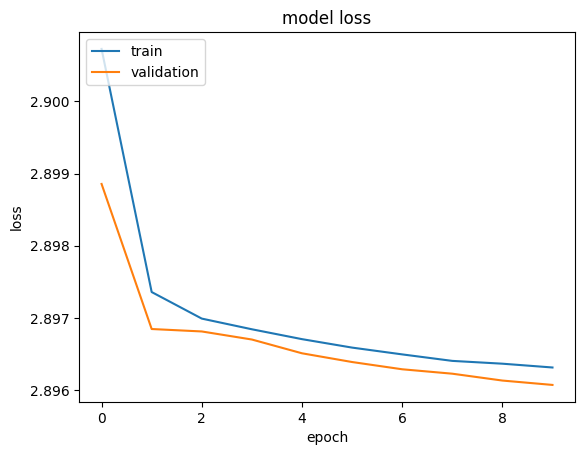

In [28]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [57]:
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)

print(int(test_ds.cardinality()))

21007


In [30]:
evaluation3 = model3.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation3.items():
  print(f"{name}: {value:.4f}")

165/165 [==============================] - 49s 291ms/step - loss: 2.8960 - accuracy: 0.0644

loss: 2.8960
accuracy: 0.0644


<a name='1'></a>
### Dropout

In [21]:
model4 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(64, 64, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(20)
])

In [22]:
model4.compile(
  optimizer = 'adam',
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics = ['accuracy'])

model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)      

In [23]:
history = model4.fit(
  train_ds,
  validation_data = valid_ds,
  epochs = 10
)

Epoch 1/10
591/591 [==============================] - 557s 941ms/step - loss: 2.1677 - accuracy: 0.2984 - val_loss: 1.0633 - val_accuracy: 0.6669
Epoch 2/10
591/591 [==============================] - 548s 927ms/step - loss: 0.8932 - accuracy: 0.7097 - val_loss: 0.6775 - val_accuracy: 0.7818
Epoch 3/10
591/591 [==============================] - 541s 915ms/step - loss: 0.6780 - accuracy: 0.7781 - val_loss: 0.5551 - val_accuracy: 0.8192
Epoch 4/10
591/591 [==============================] - 546s 924ms/step - loss: 0.5713 - accuracy: 0.8117 - val_loss: 0.4702 - val_accuracy: 0.8488
Epoch 5/10
591/591 [==============================] - 542s 918ms/step - loss: 0.4920 - accuracy: 0.8386 - val_loss: 0.4105 - val_accuracy: 0.8679
Epoch 6/10
591/591 [==============================] - 542s 916ms/step - loss: 0.4388 - accuracy: 0.8541 - val_loss: 0.3874 - val_accuracy: 0.8718
Epoch 7/10
591/591 [==============================] - 541s 916ms/step - loss: 0.3928 - accuracy: 0.8698 - val_loss: 0.3487 -

In [24]:
history.history

{'loss': [2.1676790714263916,
  0.8932360410690308,
  0.6780213117599487,
  0.5713469386100769,
  0.49196764826774597,
  0.4387631416320801,
  0.39275893568992615,
  0.35408592224121094,
  0.32327231764793396,
  0.298784464597702],
 'accuracy': [0.29841312766075134,
  0.7096667289733887,
  0.7781142592430115,
  0.8117032647132874,
  0.8386141061782837,
  0.8541126847267151,
  0.8698492646217346,
  0.8810102939605713,
  0.8924358487129211,
  0.9001851081848145],
 'val_loss': [1.0633494853973389,
  0.6775296926498413,
  0.5551397800445557,
  0.4702301025390625,
  0.4104624390602112,
  0.3874446451663971,
  0.3486754596233368,
  0.31025490164756775,
  0.28780296444892883,
  0.28741374611854553],
 'val_accuracy': [0.6668650507926941,
  0.7818376421928406,
  0.8192096948623657,
  0.8488455414772034,
  0.8678885698318481,
  0.8718162178993225,
  0.8838371634483337,
  0.8969293236732483,
  0.9049035906791687,
  0.9065698385238647]}

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


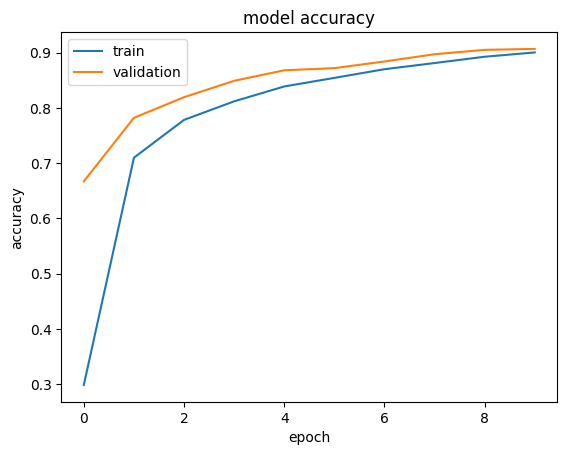

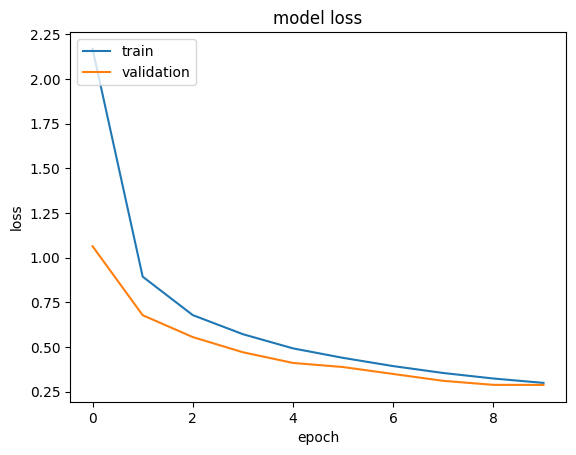

In [25]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [26]:
evaluation4 = model4.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation4.items():
  print(f"{name}: {value:.4f}")

165/165 [==============================] - 42s 250ms/step - loss: 0.2781 - accuracy: 0.9072

loss: 0.2781
accuracy: 0.9072


<a name='1'></a>
## Tests

In [39]:
probability_model = tf.keras.Sequential([model2, 
                                         tf.keras.layers.Softmax()])

In [101]:
img = tf.keras.utils.load_img(
   "/kaggle/input/yyr-expample/wxz_true1.jpg", target_size=[64, 64]
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = probability_model.predict(img_array)


1/1 [==============================] - 0s 31ms/step


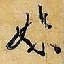

In [102]:
img

In [103]:
predictions[0]

array([0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 2.216291e-27, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00],
      dtype=float32)

In [104]:
np.argmax(predictions[0])


15

In [81]:
predictions = model2.predict(img_array)

1/1 [==============================] - 0s 35ms/step


In [82]:
predictions

array([[ -340.52692 ,  -397.95084 ,  -206.7428  ,   220.86319 ,
          131.18326 ,  -230.59204 ,   159.69731 , -1292.2291  ,
         -389.26993 ,    93.10752 ,   -37.75556 ,  -795.2115  ,
         -294.76126 ,   111.471466,  -809.7518  ,   314.50125 ,
          -97.71037 ,   -80.58241 ,  -783.03687 ,   -78.17126 ]],
      dtype=float32)